<a href="https://colab.research.google.com/github/ayyucedemirbas/machine_learning_algorithms/blob/master/Feature_selection_P-value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
np.random.seed(123)

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/ayyucedemirbas/machine_learning_algorithms/master/datasets/Breast_Cancer_Wisconsin.csv')

In [3]:
#Removing the Id and the Unnamed columns
data = data.iloc[:,1:-1]

In [4]:
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

In [5]:
corr = data.corr()

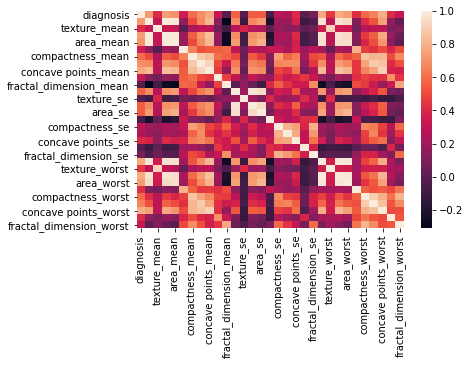

In [6]:
sns.heatmap(corr)

In [7]:
#we compare the correlation between features and remove one of two features that have a correlation higher than 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

In [10]:
selected_columns

array(['radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'concavity_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se',
       'smoothness_se', 'compactness_se', 'concavity_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'symmetry_worst', 'fractal_dimension_worst'], dtype=object)

In [11]:
#Selecting columns based on p-value
selected_columns = selected_columns[1:]
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(data.iloc[:,1:].values, data.iloc[:,0].values, SL, selected_columns)

This is what we are doing in the above code block:
We assume to null hypothesis to be “The selected combination of dependent variables do not have any effect on the independent variable”.
Then we build a small regression model and calculate the p values.
If the p values is higher than the threshold, we discard that combination of features.


In [12]:
result = pd.DataFrame()
result['diagnosis'] = data.iloc[:,0]

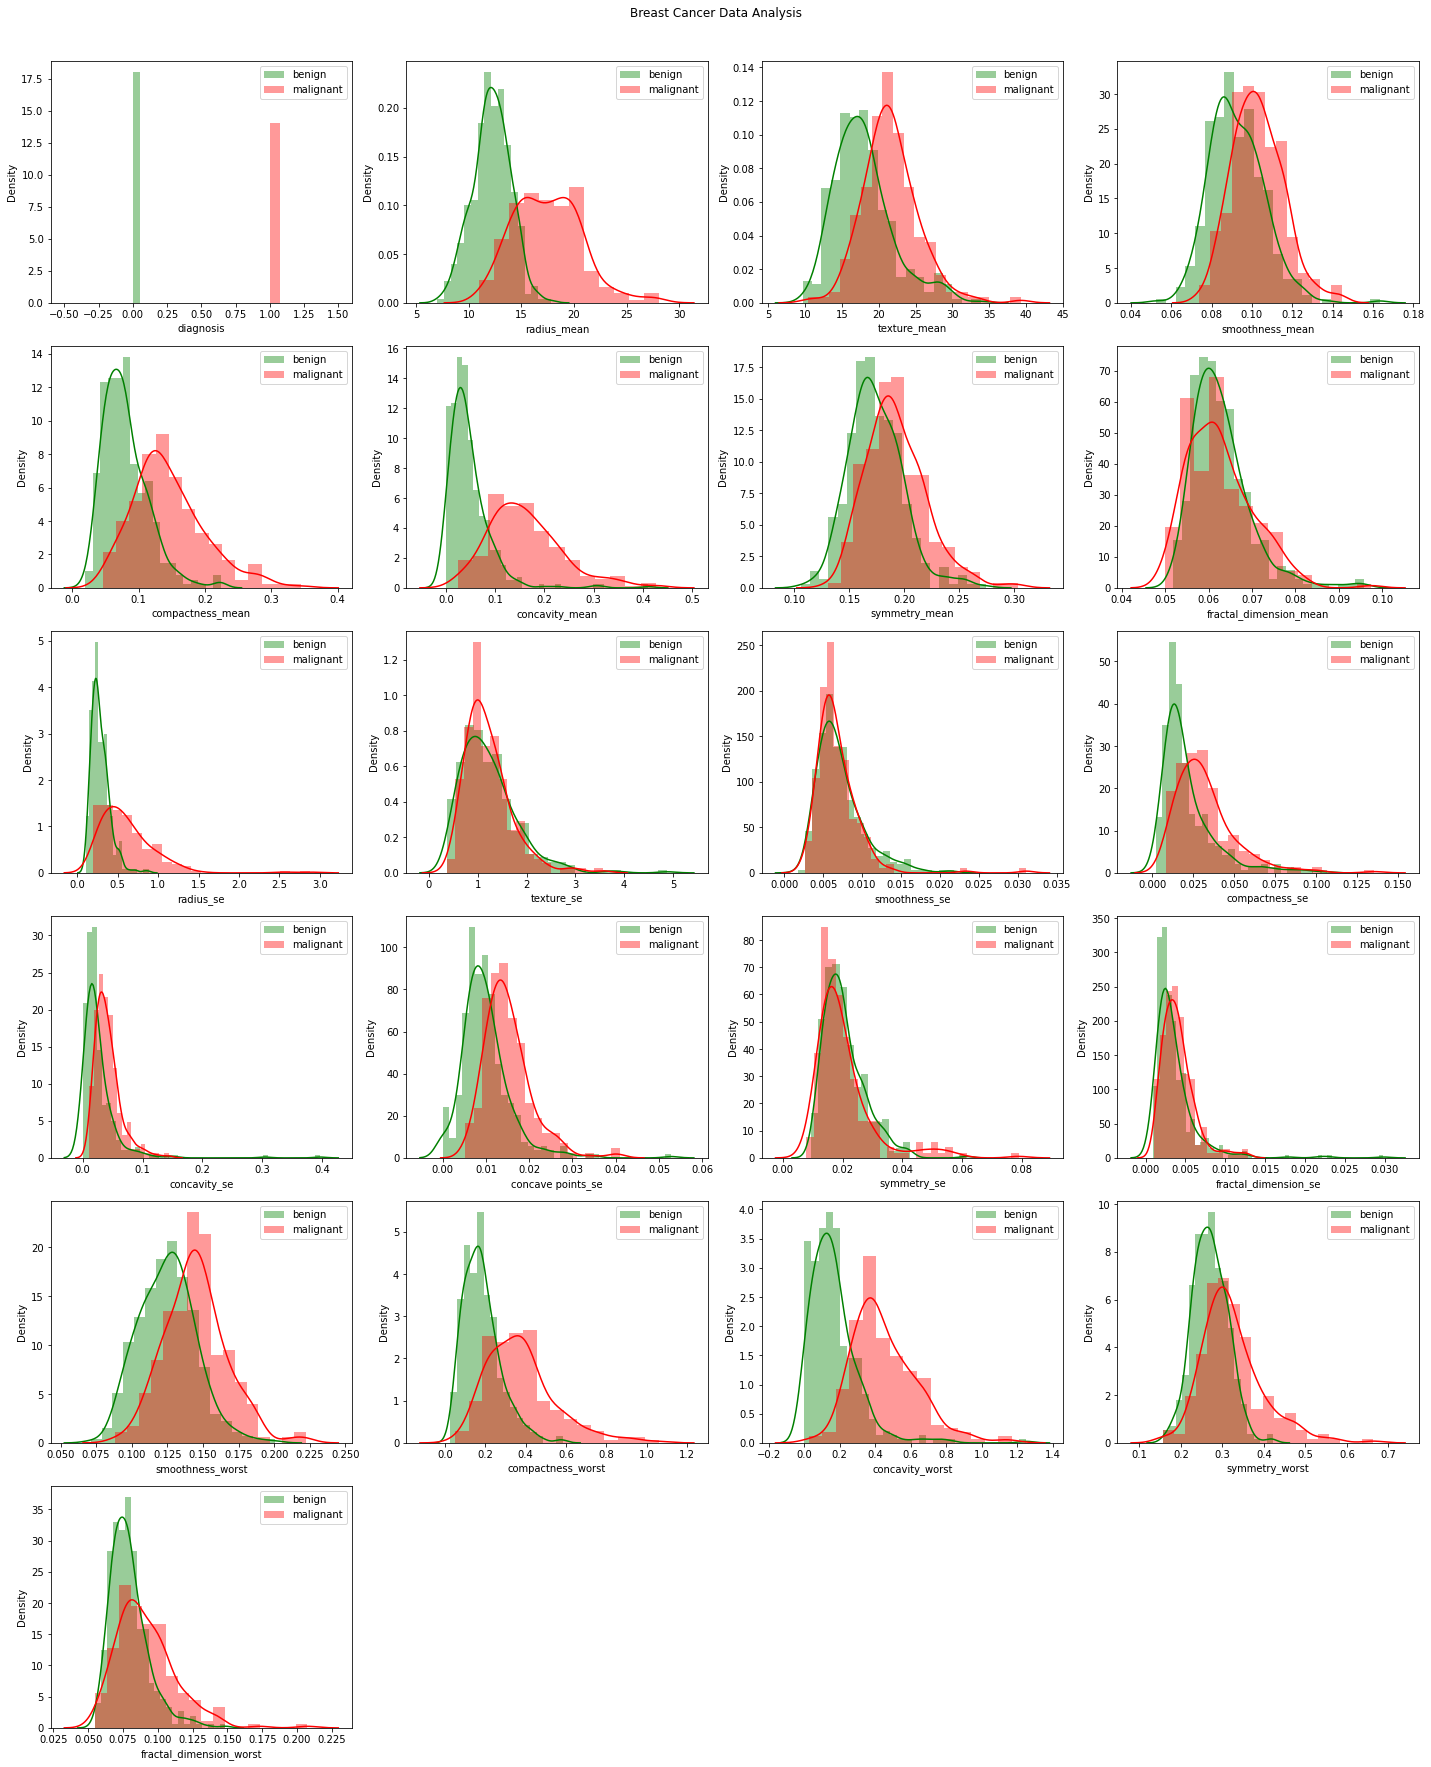

In [15]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(data[i][result['diagnosis']==0], color='g', label = 'benign')
    sns.distplot(data[i][result['diagnosis']==1], color='r', label = 'malignant')
    plt.legend(loc='best')
fig.suptitle('Breast Cancer Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(data.values, result.values, test_size = 0.2)

In [17]:
svc=SVC() # The default kernel used by SVC is the gaussian kernel
svc.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [18]:
prediction = svc.predict(x_test)

In [19]:
cm = confusion_matrix(y_test, prediction)
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/x_test.shape[0]
print(accuracy)

0.9210526315789473
